<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_jequie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolução da COVID-19 em Jequié/BA
**Fonte**: https://www.instagram.com/prefeiturajequie   
**Dados crus**: https://raw.githubusercontent.com/covidba/covid/master/jequie.csv   
**Github**: https://github.com/covidba/covid

In [0]:
cidade = 'Jequié'
cidade_file_name = 'jequie'
populacao = 155966
 
import sys
from google.colab import drive
drive.mount('/content/drive')
 
!cd drive
#!rm -r model
!git clone https://github.com/ramonfontes/Mathematical-and-Statistical-Modeling-of-COVID19-in-Brazil/ model
!pip install platypus-opt
!pip install pyswarms==1.1.0
 
#add the path were the models are
sys.path.append("model/main/")
 
from modelos import SIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'model' already exists and is not an empty directory.


In [0]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
 
data_atual = date.today().strftime("%d-%m-%Y")
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s.csv' % cidade_file_name
df = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes', 'restricao']) #, parse_dates=['data'])
df.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes', 'Medida restritiva']
df['data'] = pd.to_datetime(df['data'])

In [6]:
#Start the model with population size
model = SIR(tamanhoPop = populacao)
#create a series with the cummulative number of cases
y = df["Casos confirmados"]
#Give the number of days since the day of first case confirmed
x = range(1,len(df["Casos confirmados"]) + 1)
model.fit(x = x, y = y)
#Predict the number of cases
df["Expectativa"] = model.predict(x)

2020-05-26 22:38:37,434 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 1}
pyswarms.single.local_best:   0%|          |0/500model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))
pyswarms.single.local_best: 100%|██████████|500/500, best_cost=1.42
2020-05-26 22:40:41,264 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 1.4157837766085508, best pos: [ 0.15276973  0.06049367  0.1272039  31.72896335]


In [7]:
#Projections about the future
futherCases = pd.DataFrame.from_dict({"data":pd.date_range(start = df['data'].max()+timedelta(days=1) , end = df['data'].max()+timedelta(days=7))})

df_proj = pd.concat([df,futherCases])
#create the new series to be predicted
predictions = model.predict(df_proj)

model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))


2020-05-26 22:40:47,993 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


,Casos confirmados,Casos recuperados,Mortes,Expectativa,Casos ativos (%)
data,,,,,
2020-05-14,142.0,80.0,3.0,132.577891,43.7
2020-05-15,145.0,81.0,3.0,142.081575,44.1
2020-05-16,149.0,81.0,3.0,152.239271,45.6
2020-05-17,153.0,81.0,3.0,163.095200,47.1
2020-05-18,162.0,82.0,3.0,174.697802,49.4
2020-05-19,182.0,82.0,3.0,187.098391,54.9
2020-05-20,201.0,83.0,4.0,200.350555,58.7
2020-05-21,219.0,88.0,6.0,214.514144,59.8
2020-05-22,235.0,91.0,6.0,229.650890,61.3


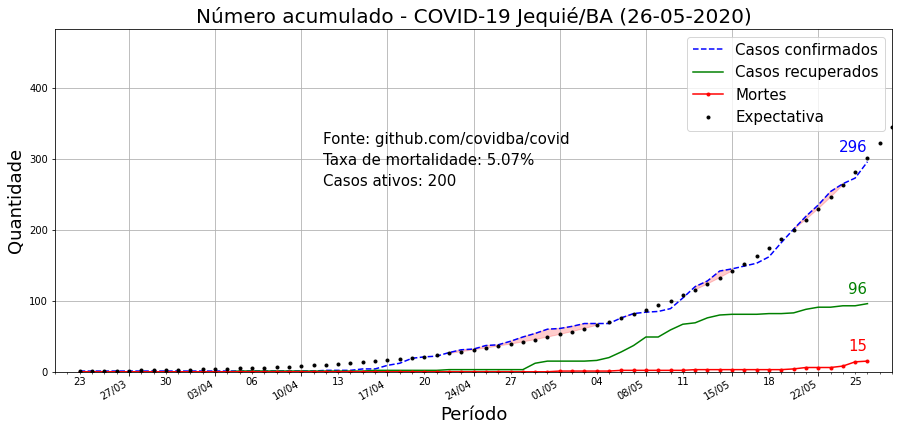

In [8]:
from matplotlib.dates import MO

casos_ativos_diaria = []
for i, v in enumerate(df['Casos confirmados']):
  casos_ativos_diaria.append(v - df['Casos recuperados'][i])
df['Casos ativos'] = casos_ativos_diaria

percentual_casos_ativos_diaria = []
for i, v in enumerate(df['Casos confirmados']):
  percentual_casos_ativos_diaria.append('%.1f' % (df['Casos ativos'][i]*100/v))
df['Casos ativos (%)'] = percentual_casos_ativos_diaria

new_df = df.append(futherCases)
new_df.reset_index(inplace=True, drop=True)
new_df['Expectativa'] = predictions

#set date as index
lista_data = new_df['data']
new_df.set_index('data', inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']

df2 = new_df
del df2['Casos ativos']
del df2['Medida restritiva']
new_df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# ADICIONAR VALORES
casos_confirmados_series = pd.DataFrame(new_df['Casos confirmados'])
ultimo_caso_valido_id = casos_confirmados_series.index.get_loc(casos_confirmados_series.last_valid_index())
def adicionar_valores(caso, color):
  ax.annotate(int(new_df[caso].max()), xy=(lista_data[ultimo_caso_valido_id], new_df[caso].max()), 
              xycoords='data', ha='right', fontsize=15, color=color,
              xytext=(0, 10), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

casos_ativos = int(new_df['Casos confirmados'].max() - new_df['Casos recuperados'].max())
taxa_mortalidade = (100 * new_df['Mortes'].max()) / new_df['Casos confirmados'].max()
url_expectativa = 'github.com/covidba/covid'
def plotar_info(texto, y):
  ax.annotate(texto , xy=(lista_data.min() + timedelta(days=10), new_df['Expectativa'].max()/2+y), 
            xycoords='data', ha='left', fontsize=15, color='black',
            xytext=(120, 0), textcoords='offset points')

plotar_info('Casos ativos: %s' % casos_ativos, 20)
plotar_info('Taxa de mortalidade: %.2f%%' % taxa_mortalidade, 50)
plotar_info('Fonte: %s' % url_expectativa, 80)

ax.fill_between(new_df.index, new_df['Casos confirmados'], new_df['Expectativa'], 
                where=new_df['Casos confirmados']>=new_df['Expectativa'], alpha=0.2, color='red')

ax.set_ylim(0, new_df['Expectativa'].max())
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()-timedelta(days=5)])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
new_df.tail(20)

11
11
11


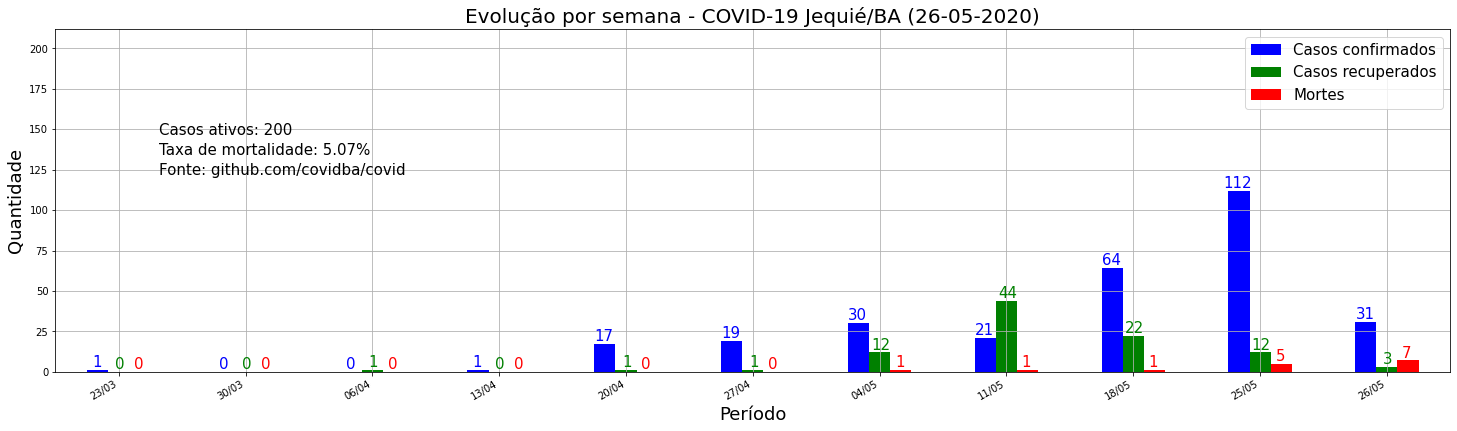

In [14]:
frequencia = 7
colors = ['b','g','r', 'orange']

dict_diaria = dict()
dict_diaria['data'] = []
dict_diaria['confirmados_diaria'] = []
dict_diaria['recuperados_diaria'] = []
dict_diaria['mortes_diaria'] = []

casos_confirmados_diaria = []
casos_recuperados_diaria = []
casos_mortes_diaria = []

def alimentar_lista(lista, texto):
  for id, v in enumerate(new_df[texto]):
    if not pd.isnull(v):
      if(id) == 0:
        lista.append(v)  
      else:
        lista.append(v - new_df[texto][id-1])

alimentar_lista(casos_confirmados_diaria, 'Casos confirmados')
alimentar_lista(casos_recuperados_diaria, 'Casos recuperados')
alimentar_lista(casos_mortes_diaria, 'Mortes')

def alimentar_dict(lista, texto):
  soma_casos = 0
  for id, v in enumerate(lista):
    if not pd.isnull(v):
      if id % frequencia == 0:
        if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])
        if id == 0:
          dict_diaria[texto].append(v)
        else:
          if(len(lista)-1 == id):
            dict_diaria[texto].append(soma_casos)
            dict_diaria[texto].append(v)
            if texto == 'confirmados_diaria':
              dict_diaria['data'].append(lista_data.max()+timedelta(days=1))
          else:
            dict_diaria[texto].append(soma_casos)
            soma_casos = v
      else:
        soma_casos += v
        if(len(lista)-1 == id):
          dict_diaria[texto].append(soma_casos)
          if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])

alimentar_dict(casos_confirmados_diaria, 'confirmados_diaria')
alimentar_dict(casos_recuperados_diaria, 'recuperados_diaria')
alimentar_dict(casos_mortes_diaria, 'mortes_diaria')
#alimentar_dict(casos_ativos_diaria, 'ativos_diaria')

print(len(dict_diaria['data']))

print(len(dict_diaria['mortes_diaria']))
print(len(dict_diaria['confirmados_diaria']))
df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes'] #, 'Casos ativos']
novo_df = df_diaria

df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(25,7))
df_diaria.plot(ax=ax, color=colors, kind='bar')
fig.autofmt_xdate()

# workaround para erro em bar kind
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df_diaria.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def plotar_valores(texto, cor, x):
  for i, v in enumerate(df_diaria[texto]):
    if not pd.isnull(v):
      ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color=cor,
                xytext=(x, 3), textcoords='offset points')

plotar_valores('Casos confirmados', 'b', -22)
plotar_valores('Casos recuperados', 'g', 1)
plotar_valores('Mortes', 'r', 20)
#plotar_valores('Casos ativos', 'orange', 26)

def plotar_info(texto, y):
  ax.annotate(texto , xy=(df_diaria['Mortes'][4], df_diaria['Casos confirmados'].max()-10), 
              xycoords='data', ha='left', fontsize=15, color='black', 
              xytext=(40, df_diaria['Casos confirmados'].max()-y), textcoords='offset points')

plotar_info('Casos ativos: %s' % casos_ativos, 40)
plotar_info('Taxa de mortalidade: %.2f%%' % taxa_mortalidade, 60)
plotar_info('Fonte: %s' % url_expectativa, 80)

ax.set_ylim([0, df_diaria['Casos confirmados'].max() + 100])
ax.set_title("Evolução por semana - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

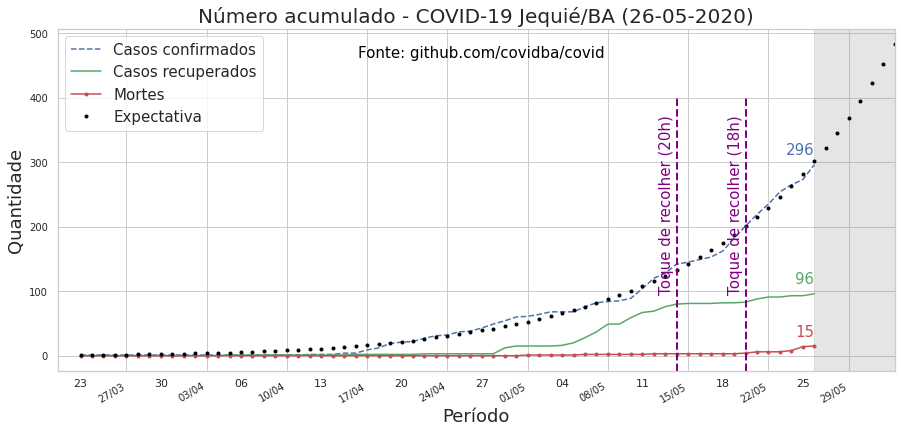

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
new_df1 = new_df
if 'Casos ativos' in new_df1:
  del new_df1['Casos ativos']
if 'Medida restritiva' in new_df1:
  del new_df1['Medida restritiva']
new_df1.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), lista_data.max().strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

def adicionar_medida(texto, id, color='green'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], ymax=0.8)
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], 100), rotation=90,
            xycoords='data', ha='center', fontsize=15, color=color,
            xytext=(-10, 0), textcoords='offset points')

# ADICIONAR MEDIDAS
def adicionar_medidas():
  for id, medida in enumerate(df['Medida restritiva']):
    # toque de recolher
    if not pd.isnull(medida):
      if medida == 0:
        adicionar_medida('Comércio aberto', id) 
      elif medida == 1:
        adicionar_medida('Comércio fechado', id, color='purple') 
      elif medida > 1:
        if medida == 24:
          adicionar_medida('Saída do toque de recolher', id)
        else:
          adicionar_medida('Toque de recolher (%sh)' % int(medida), id, color='purple')      
      elif medida == -1:
        adicionar_medida('Entrada no lockdown', id, color='purple')
      elif str(medida) == '-0':
        adicionar_medida('Saída do lockdown', id)
  
adicionar_medidas()

# ADICIONAR VALORES  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.annotate('Fonte: %s' % url_expectativa , xy=(df['data'].min()+timedelta(days=35), new_df['Expectativa'].max()-20), 
            xycoords='data', ha='center', fontsize=15, color='black', xytext=(0, 0), textcoords='offset points')

ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

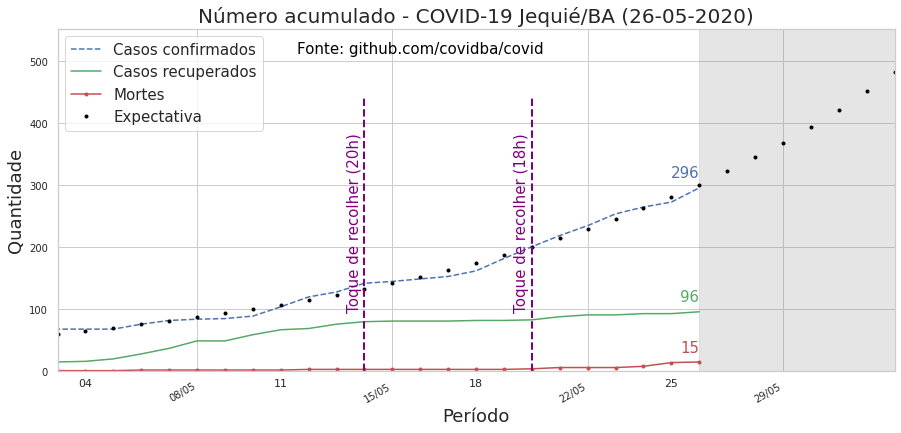

In [30]:
fig, ax = plt.subplots(figsize=(15,7))
new_df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), lista_data.max().strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')
adicionar_medidas()

# ADICIONAR VALORES
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.annotate('Fonte: %s' % url_expectativa , xy=(df['data'].max()-timedelta(days=10), new_df['Expectativa'].max() + 30), 
            xycoords='data', ha='center', fontsize=15, color='black', xytext=(0, 0), textcoords='offset points')

ax.set_ylim([0, new_df['Expectativa'].max() + 70])
ax.set_xlim([lista_data.max() - timedelta(days=30), lista_data.max()])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

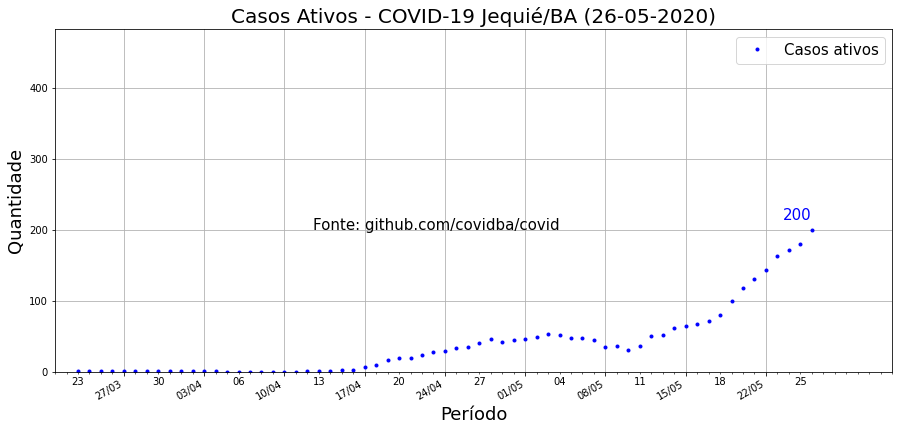

In [19]:
pd_ativos = pd.DataFrame.from_dict({"data":pd.date_range(start = df['data'].min(), end = df['data'].max()),
                                    "Casos Ativos": np.nan})
pd_ativos['data'] = pd.to_datetime(df['data'])
pd_ativos.columns = ['data', 'Casos ativos']

#set date as index
pd_ativos['Casos ativos'] = pd.Series(df['Casos ativos']).dropna()
pd_ativos.set_index('data', inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b']
ls = ['.']
pd_ativos.plot(ax=ax, color=colors, style=ls, lw=3)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

ax.annotate(int(pd_ativos['Casos ativos'].max()), xy=(lista_data[ultimo_caso_valido_id], pd_ativos['Casos ativos'].max()), 
              xycoords='data', ha='right', fontsize=15, color='blue',
              xytext=(0, 10), textcoords='offset points')

def plotar_info(texto, x, y):
  ax.annotate(texto , xy=(lista_data.min() + timedelta(days=10), pd_ativos['Casos ativos'].max()), 
            xycoords='data', ha='left', fontsize=15, color='black',
            xytext=(x, 0), textcoords='offset points')
plotar_info('Fonte: %s' % url_expectativa, 120, 80)

ax.set_ylim(0, new_df['Expectativa'].max())
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()])
ax.set_title("Casos Ativos - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

# Situação por Bairro



Text(0, 0, 'Fonte: github.com/covidba/covid')

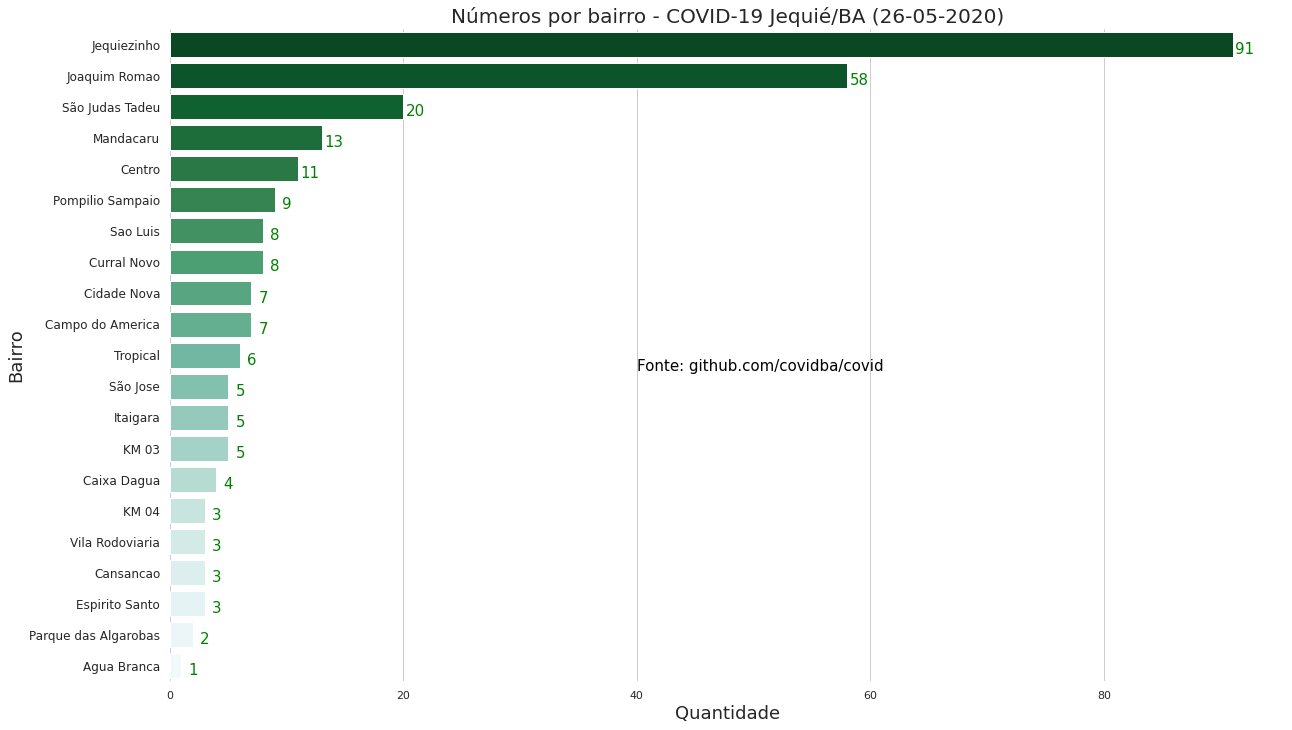

In [31]:
import seaborn as sns
sns.set(style="whitegrid")

url = 'https://raw.githubusercontent.com/covidba/covid/master/%s-bairro.csv' % cidade_file_name
df_bairro = pd.read_csv(url, usecols=['Bairro', 'Quantidade'])
df_bairro.head()

bairro = df_bairro['Bairro']
quantidade = df_bairro['Quantidade']

df_bairro = pd.DataFrame({'Bairro': bairro,
                   'Quantidade': quantidade})

fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(x='Quantidade', y='Bairro', data=df_bairro, ax=ax, palette="BuGn_r",  orient = 'h')
sns.despine(left=True, bottom=True)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

for i, v in enumerate(quantidade):
    ax.annotate(int(v), xy=(v, i+0.3), xycoords='data', ha='center', fontsize=15, color='green',
              xytext=(12, 0), textcoords='offset points')
    

ax.set_title("Números por bairro - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Bairro', fontsize=18)
ax.set_xlabel('Quantidade', fontsize=18)

url_fonte = 'github.com/covidba/covid'
ax.annotate('Fonte: %s' % url_fonte, xy=(40, len(bairro)/2), 
          xycoords='data', ha='left', fontsize=15, color='black',
          xytext=(0, 0), textcoords='offset points')

# Situação por faixa etária



Text(0, 0, 'Fonte: github.com/covidba/covid')

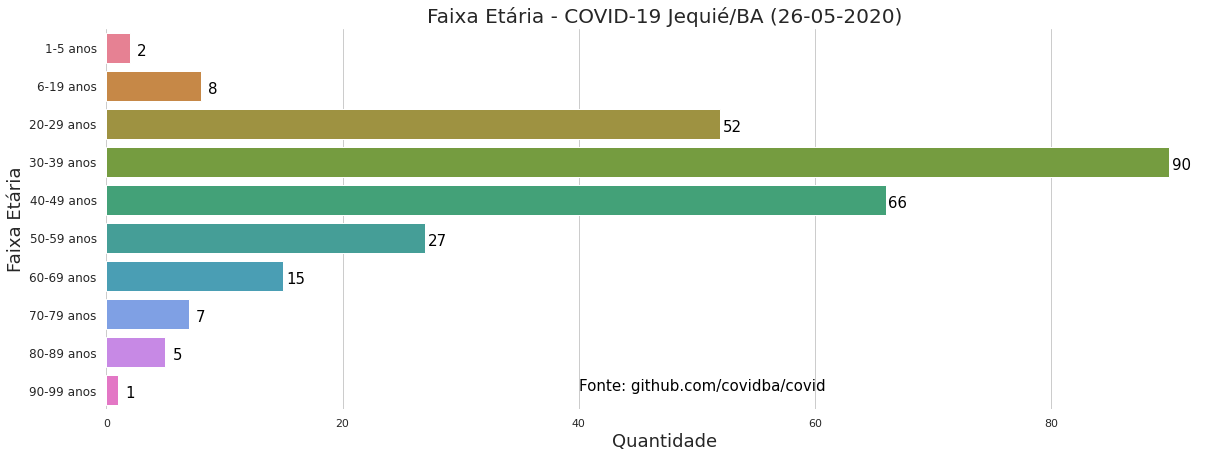

In [32]:
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s-faixa.csv' % cidade_file_name
df_etaria = pd.read_csv(url, usecols=['Faixa Etaria', 'Quantidade'])
df_etaria.head()

faixa = df_etaria['Faixa Etaria']
quantidade = df_etaria['Quantidade']

df_etaria = pd.DataFrame({'Faixa Etaria': faixa,
                   'Quantidade': quantidade})

fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x='Quantidade', y='Faixa Etaria', data=df_etaria, ax=ax, palette="husl",  orient='h')
sns.despine(left=True, bottom=True)

for i, v in enumerate(quantidade):
    ax.annotate(int(v), xy=(v, i+0.2), xycoords='data', ha='center', fontsize=15, color='black',
              xytext=(12, 0), textcoords='offset points')
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("Faixa Etária - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Faixa Etária', fontsize=18)
ax.set_xlabel('Quantidade', fontsize=18)

ax.annotate('Fonte: %s' % url_fonte, xy=(40, len(faixa)-1), 
          xycoords='data', ha='left', fontsize=15, color='black',
          xytext=(0, 0), textcoords='offset points')